# PyTorch recurrent neural networks

This notebook demosntrates the three most common types of recurrent neural networks. 
Namely, we focus on: 
    Simple recurrent neural network   (RNN) 
    Gated recurrent units             (GRU)
    Long short term memory netowrk    (LSTM) 

The models are nicely demonstrated and explained in the following post:  
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

The models are trained on a one dimensional time series of a noisy sin-wave. 


In [1]:
# load packages and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
%matplotlib inline
from torch import nn
from torch.autograd import Variable
import time

In [2]:
use_gpu=torch.cuda.is_available()
print("GPU is available: ",  use_gpu)


GPU is available:  True


In [3]:
# Parameters
look_back=5        # historic time window
look_forward=1        # prediction time horizont
hidden_size= 4       # dimension of hidden variable h
num_layer= 2          # number of LSTM layers
dropout=   0.3      # dropout rate after each LSTM layer

epochs=100

sample_size=2

In [4]:
# generate data 
average_steps=30
std=10
R={}
def generate_trajectories(sample= sample_size, average_steps=average_steps, std=std):
    for num in np.arange(sample):
        start=np.array(np.random.choice([0, 1], 2))
        if (start==np.array([1,1])).all():
            start=np.array([ 1, np.random.rand()])
            end= np.array([ 0, np.random.rand()])
        elif (start==np.array([0,0])).all():
            start=np.array([np.random.rand(), 1])
            end= np.array([ np.random.rand(), 0])
        else: 
            start=start*np.random.rand(2)
            end= start*np.random.rand(2)+(start==0)*1.
        a=np.vstack((start, end))
        v=end-start
        
        n=np.clip(int(np.random.normal(average_steps, std)), 1, 10000)
        v= v/n
        x=np.linspace(start[0], end[0], n, endpoint=True)
        y=np.linspace(start[1], end[1], n, endpoint=True)
        r=np.vstack((x,y))
        R[num]=r
    return R 


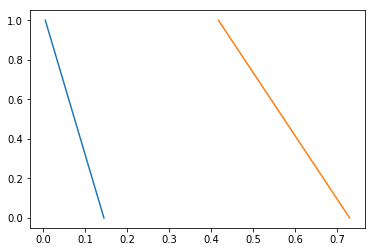

In [5]:
dataset=generate_trajectories()
for index, trajectory in dataset.items():
    plt.plot(trajectory[0], trajectory[1],  label="train") 
plt.show()


In [6]:
def create_dataset(dataset, look_back, look_forward):
    dataX, dataY = {}, {}
    for index, item in dataset.items():
        dataX[index]=[]
        dataY[index]=[]
        for i in range(np.shape(item)[1] - look_back- look_forward):
            a = item[:, i:(i + look_back)]
            dataX[index].append(a)
            dataY[index].append(item[:,i + look_back:(i + look_back+look_forward)])
    return dataX, dataY

In [7]:

data_X, data_Y = create_dataset(dataset, look_back, look_forward)


In [8]:
train_x={} 
test_x={}
train_y={} 
test_y={} 


split=0.7
# Slit data to train and test data
for index, item in data_X.items():
    if index< split*len(data_X):
        train_X = item
     
        train_X = np.array(train_X).reshape(2, -1, look_back)
     
        train_x[index] = torch.from_numpy(train_X).cuda()
    else:
        test_X = item
        test_X = np.array(test_X).reshape(2, -1, look_back)
        test_x[index] = torch.from_numpy(test_X).cuda()

for index, item in data_Y.items():
    if index< split*len(data_X):
        train_Y = item
        train_Y = np.array(train_Y).reshape(2, -1,  look_forward)
        train_y[index] = torch.from_numpy(train_Y).cuda()
    else:
        test_Y = item
        test_Y = np.array(test_Y).reshape(2, -1,  look_forward)
        test_y[index] = torch.from_numpy(test_Y).cuda()
        
    

In [9]:
# Neural netowrk 

class model(nn.Module):
    def __init__(self, module, input_size, hidden_size, output_size, num_layers=num_layer, dropout=dropout):
        if module=="LSTM":
            super(model, self).__init__()    
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 

        elif module=="RNN":
            super(model, self).__init__()    
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 
        elif module=="GRU":
            super(model, self).__init__()    
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 
        else:
            print("No valid model")
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
    
    def predict(self, inp, input_size, future=0):
        outputs=[]
        for i in range(future):# if we should predict the future
            x, _ = self.rnn(inp) # (seq, batch, hidden)
            s, b, h = x.shape
            x = x.view(s*b, h)
            x = self.reg(x)
            x = x.view(s, b, -1)
            outputs += [x]
            inp[:,:,:(input_size-1)]=inp[:,:,1:]
            inp[:,:,-1]=x[-1].item()
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [10]:
# initialize neural nets
net={}
models=['LSTM', 'RNN', 'GRU']
optimizer={}
for name in models:
    net[name]=model(name, look_back, hidden_size, look_forward).cuda()
    optimizer[name] = torch.optim.Adam(net[name].parameters(), lr=1e-2)

criterion = nn.MSELoss()
print(net)


{'LSTM': model(
  (rnn): LSTM(5, 4, num_layers=2, dropout=0.3)
  (reg): Linear(in_features=4, out_features=1, bias=True)
), 'RNN': model(
  (rnn): RNN(5, 4, num_layers=2, dropout=0.3)
  (reg): Linear(in_features=4, out_features=1, bias=True)
), 'GRU': model(
  (rnn): GRU(5, 4, num_layers=2, dropout=0.3)
  (reg): Linear(in_features=4, out_features=1, bias=True)
)}


In [14]:
# training 
print(train_x)
t0= time.time()
for e in range(epochs):
    if (e+1) % 100 == 0: 
        dt=time.time()-t0
        t0=dt+t0
        print('-'* 20 + ' Epoch {} - {:.2f}% - Time {:.2f}s '.format(e+1, (e+1)/epochs*100, dt) +'-'*20)
    for i in np.arange(len(train_x)):
        var_x = Variable(train_x[i])
        var_y = Variable(train_y[i])
        print(var_x)
        print(var_y)
        for name in models:
            out = net[name](var_x)
            loss = criterion(out, var_y)
            optimizer[name].zero_grad()
            loss.backward()
            optimizer[name].step()
        if (e+1) % 100 == 0: 
            print('{}: Loss: {:.5f}'.format(name, loss.item()))



{0: tensor([[[ 0.1440,  0.1371,  0.1301,  0.1231,  0.1161],
         [ 0.0000,  0.0500,  0.1000,  0.1500,  0.2000],
         [ 0.1371,  0.1301,  0.1231,  0.1161,  0.1091],
         [ 0.0500,  0.1000,  0.1500,  0.2000,  0.2500],
         [ 0.1301,  0.1231,  0.1161,  0.1091,  0.1021],
         [ 0.1000,  0.1500,  0.2000,  0.2500,  0.3000],
         [ 0.1231,  0.1161,  0.1091,  0.1021,  0.0951],
         [ 0.1500,  0.2000,  0.2500,  0.3000,  0.3500],
         [ 0.1161,  0.1091,  0.1021,  0.0951,  0.0882],
         [ 0.2000,  0.2500,  0.3000,  0.3500,  0.4000],
         [ 0.1091,  0.1021,  0.0951,  0.0882,  0.0812],
         [ 0.2500,  0.3000,  0.3500,  0.4000,  0.4500],
         [ 0.1021,  0.0951,  0.0882,  0.0812,  0.0742],
         [ 0.3000,  0.3500,  0.4000,  0.4500,  0.5000],
         [ 0.0951,  0.0882,  0.0812,  0.0742,  0.0672]],

        [[ 0.3500,  0.4000,  0.4500,  0.5000,  0.5500],
         [ 0.0882,  0.0812,  0.0742,  0.0672,  0.0602],
         [ 0.4000,  0.4500,  0.5000,  0.55

RuntimeError: CUDNN_STATUS_EXECUTION_FAILED

In [ ]:
for name in models:
    net[name] = net[name].eval() 

In [ ]:
test={}
test_x=Variable(train_x)
for name in models: 
    test[name] = net[name](test_x)
    loss = criterion(test[name], train_y)
    print('{}: Loss: {:.5f}'.format(name, loss.item()))


In [ ]:

for name in models:
    plt.plot( test[name].view(-1).data.cpu().numpy(), label=name)
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

#### 